In [1]:
import featurization
import helpers
import model_neighbors

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
test_geodf = featurization.all_featurization("bike-data/sc-bike-data-ending1109.csv")

Dropping 0 entries where end time was before start time


In [17]:
train_geodf = featurization.all_featurization("all-sc-bike-data-1101.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Dropping 1 entries where end time was before start time


In [3]:
knn_model = pickle.load(open('knn_pickle.p', "rb"))
scaler = pickle.load(open('scaler.p', "rb"))
X_test_raw = test_geodf[["lon", "lat", "time_of_day_start", "day_of_week"]]
X_test = scaler.transform(X_test_raw.astype(float))
y_true = test_geodf['idle_hours']
y_pred = knn_model.predict(X_test)

In [18]:
#avg_rentals_per_bike_per_day
train_geodf.groupby([train_geodf['local_time_start'].dt.date, train_geodf['bike_id']])['idle_time'].count().mean()

3.857608695652174

So bikes are rented, on average, 3.8 times per day. Lets say each rental makes $2. And nighttime hours don't count because bikes are so rarely rented then. This means on average a bike should make about 40 cents an hour for the company.

In [20]:
2.8*2/14

0.39999999999999997

In [99]:
cost_relocate = 5
cost_idle = 1

Using the most basic math, you should relocate a bike if you expect it to sit for longer than 12.5 hours.

In [100]:
relocate_time = cost_relocate/cost_idle
relocate_time

5.0

But what if we apply our exponential distributions of bike distributions to make a profit curve? At what certainty of sitting for 12.5 hours do we maximize profit?

This tells us the probability that a bike will still be there after our break-even relocate time

In [101]:
prob_bike_is_there = [1-scs.expon(scale=y_pred[i]).cdf(relocate_time) for i in range(len(y_pred))]

In [102]:
labels = (y_true > relocate_time).astype(int)

In [103]:
def standard_confusion_matrix(y_t, y_p):
    y_true = np.array(y_t)
    y_predict = np.array(y_p)
    tp = np.sum((y_true == y_predict) & (y_true == 1))
    fp = np.sum((y_true != y_predict) & (y_true == 0))
    fn = np.sum((y_true != y_predict) & (y_true == 1))
    tn = np.sum((y_true == y_predict) & (y_true == 0))
    return np.array([[tp, fp], [fn, tn]])

A test case on the confusion matrix function

In [104]:
bike_is_there_10 = np.array(prob_bike_is_there) > 0.1
standard_confusion_matrix(labels, bike_is_there_10)

array([[215, 349],
       [ 85, 660]])

From the training data, once a bike exceeds the 12.5 hour mark, it sits, on average, for another 6 hours

***** consider if this is right? should it be multiplied by the entire sit time or just the part over 12.5 hours?

In [105]:
cost_matrix = np.array([[ 6,  -10],
                        [ 0,  0]])

In [106]:
def profit_curve(cost_matrix, thresholds, probs, labels):
    '''function profit_curve(cost_benefit, predicted_probs, labels):
    1. Sort instances by their prediction strength (the probabilities)
       - Add 1 at the beginning so that you consider all thresholds
    2. For every instance in decreasing order of probability:
       1. Set the threshold to be the probability
       2. Set everything above the threshold to the positive class
       3. Calculate the confusion matrix
       4. Compute the expected profit:
           - multiply each of the 4 entries in the confusion matrix by
             their associated entry in the cost-benefit matrix
           - sum up these values
           - divide by the total number of data points
    3. Return an array of the profits and their associated thresholds'''
    profits = []
    for t in thresholds:
        cf = standard_confusion_matrix(labels, probs>t)
        profits.append(np.sum(cf*cost_matrix)/np.sum(cf))
#     return (thresholds,profits)  
    return np.array([thresholds,profits]).T

In [107]:
thresholds = np.linspace(0, 1)

In [108]:
profit = profit_curve(cost_matrix, thresholds, prob_bike_is_there, labels)

In [109]:
profit[:,1].max()

0.03819709702062643

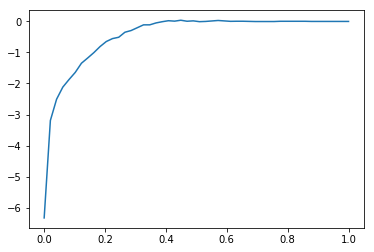

In [110]:
plt.plot(profit[:,0], profit[:,1])

In [ ]:
def plot_profit_curve(model, cost_benefit, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    probs = model.predict_proba(X_test)[:,1]
    profits = profit_curve(cost_benefit, probs, y_test)[:,1]
    percentages = np.arange(0, 100, 100. / len(profits))
    plt.plot(percentages, profits, label=model.__class__.__name__)
    plt.title("Profit Curve")
    plt.xlabel("Percentage of test instances that we predict to churn")
    plt.ylabel("Profit")